# Um Estudo sobre Detecção de Fraude em Cartões de Crédito

As fraudes em cartões de crédito afetam consumidores e instituições financeiras globalmente, representando um problema significativo. Trata-se de atividades fraudulentas em que criminosos obtêm informações pessoais e financeiras dos titulares dos cartões para realizar transações não autorizadas. Essas transações fraudulentas podem envolver desde compras online até saques em dinheiro ou transferências bancárias.

Neste projeto, iremos analisar uma base de dados que contém registros de transações realizadas com cartões de crédito, incluindo transações normais e fraudulentas.

Após a análise da base de dados, iremos criar um modelo de machine learning com a finalidade de classificar se uma determinada transação foi considerada normal ou uma fraude.

In [23]:
#@title Bibliotecas

# Bibliotecas para tratarmos e visualizarmos os dados
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Bibliotecas com os modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Bibliotecas para separar os dados
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Bibliotecas para a avaliação dos modelos
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix



## Importando os dados

O conjunto de dados disponibilizado refere-se a transações efetuadas por titulares de cartões de crédito europeus no mês de setembro de 2013. Este conjunto contém apenas variáveis numéricas de entrada que foram obtidas por meio de uma transformação PCA. Devido a preocupações com a confidencialidade, não foram fornecidos os nomes originais das colunas, sendo assim, elas são identificadas como [V1, V2, V3 ... V28].

Além disso, é importante mencionar a existência da coluna "Time". Os dados foram coletados ao longo de um período de dois dias, e a coluna "Time" indica o exato segundo em que cada transação ocorreu dentro desse intervalo. No entanto, iremos utilizar essa coluna apenas para visualização dos dados. Para facilitar essa visualização, criei uma outra coluna chamada "Hour", que registra apenas a hora da transação, sem considerar os segundos.

Outras colunas presentes no conjunto de dados incluem:

- Hour: Indica a hora em que a transação foi realizada dentro do intervalo de dois dias (0-48 horas).
- Amount: Representa o valor gasto na transação.
- Class: Essa coluna possui valores binários (0, 1).
    - 0: Indica que a transação é considerada normal.
    - 1: Indica que a transação é classificada como fraudulenta.

In [24]:
#@title Importando a base de dados e trocando a coluna Time por Hour

# DOWNLOAD DA BASE DE DADOS https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

data = pd.read_csv('database/creditcardfraud.csv')
data['Hour'] = data['Time'] // 3600
df = data.drop('Time', axis=1)

In [25]:
#@title Visualizando as 5 primeiras linhas
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0


In [26]:
#@title Pegando o total de linhas e colunas

print(f"A base de dados contém {df.shape[0]} linhas e {df.shape[1]} colunas.")
total_linhas = df.shape[0]

A base de dados contém 284807 linhas e 31 colunas.


In [27]:
#@title Usando value counts para calcular quantas transações possuem classe 0 e classe 1

transacoes_normais, transacoes_fraudulentas = df['Class'].value_counts()

print(f"Nas quais {transacoes_normais} representam as transações normais, e {transacoes_fraudulentas} representam as transações fraudulentas.")

Nas quais 284315 representam as transações normais, e 492 representam as transações fraudulentas.


In [28]:
#@title Calculando a porcentagem dos registros de classe 1 com relação ao total de registros

print(f'Quando comparamos com o total de registros, as fraudes representam MENOS de 1% dos casos, mais precisamente {(transacoes_fraudulentas/total_linhas)*100:.3f}% dos casos.')

Quando comparamos com o total de registros, as fraudes representam MENOS de 1% dos casos, mais precisamente 0.173% dos casos.


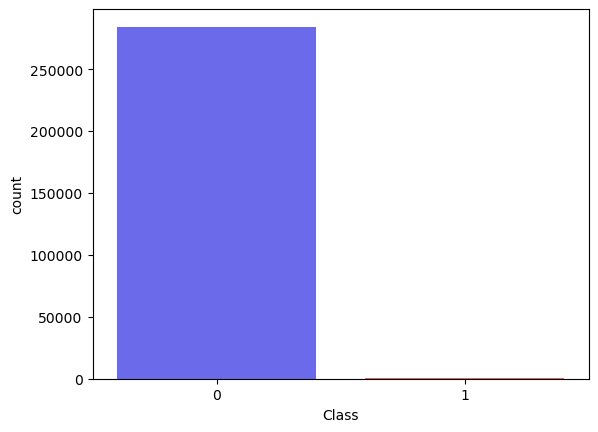

In [29]:
#@title Comparando a quantidade de Class 0(Transação normal) com a quantidade de Class 1 (Transação fraudulenta) na base de dados.
# plotar a nova distribuição de classes
sns.countplot(x=df.Class, palette='seismic');

 com o .describe() podemos análisar alguns dados estatisticos sobre nossa base de dados, no caso Hour, Amount e Class.<br>

Podemos ver algo interessante na coluna Amount, A média de gastos é 88,34, porém a mediana é de 22,00. Isso mostra que há um valor discrepante dos outros que está elevando o valor da média a tornando distante do valor da mediana. E quando olhamos para o MAX da coluna amount podemos ver que o valor maximo foi de 25.691,16

In [30]:
#@title ...
df[['Hour', 'Amount', 'Class']].describe()

,Hour,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,25.845703,88.349619,0.001727
std,13.184831,250.120109,0.041527
min,0.000000,0.000000,0.000000
25%,15.000000,5.600000,0.000000
50%,23.000000,22.000000,0.000000
75%,38.000000,77.165000,0.000000
max,47.000000,25691.160000,1.000000


## Visualizando alguns dados
Usando boxplot, podemos análisar a quantia gasta em uma transação normal e a quantia gasta nas transações fraudulentas.

Nas transações normais podemos ver que:
 - A mediana(risco dentro da primeira caixa) é um valor abaixo dos 50, provavelmente próximo de 20;
 - E a média nas transações normais(pequeno triangulo acima da caixa) é um valor abaixo dos 100, proximo de 90.<br>

Já nas transações com fraude temos que:
 - A mediana é bem mais baixa, diria que inferior a 10;
 - Por outro lado a média supera os 100 das transações normais, algo próximo a 120.

Também podemos notar que em ambas temos dados discrepantes(outliers);
- Nas transações normais eles começam pouco abaixo de 200;
- E nas transações fraudulentas acima de 250.

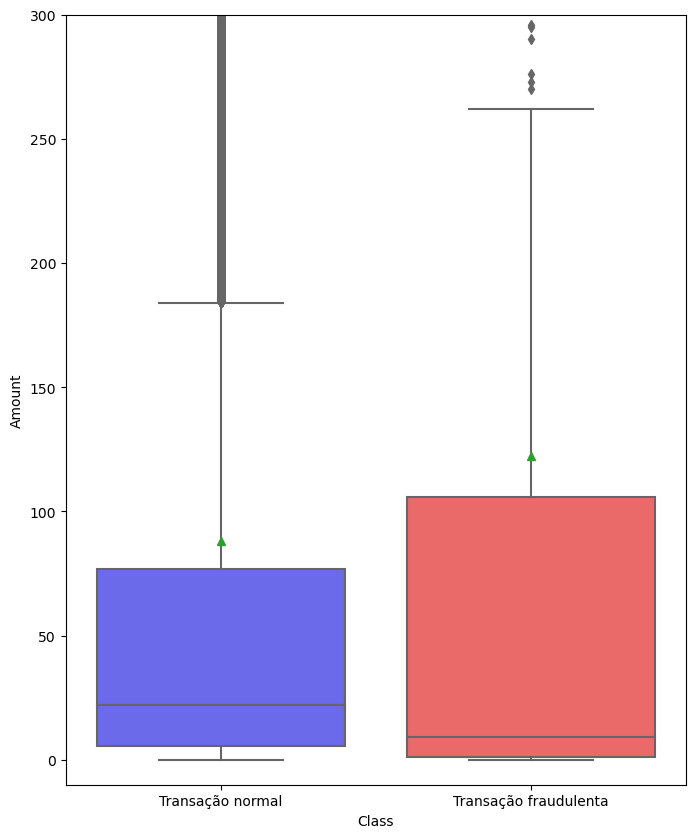

In [31]:
#@title ...
fig, ax = plt.subplots(figsize=(8,10))

# showmeans é o ponto verde que indica o valor da média
sns.boxplot(x=df.Class, y=df.Amount, showmeans=True, ax=ax, palette='seismic')

# Tamanho do eixo Y, inicio, fim
ax.set_ylim(-10, 300)

# Labels dos boxplots
plt.xticks([0, 1], ['Transação normal', 'Transação fraudulenta'])

plt.show()

Aqui foram plotados dois histogramas para analisar a frequência das transações com cartões de crédito.

O primeiro histograma exibe as transações normais e as respectivas horas em que foram realizadas.
O segundo histograma exibe as transações fraudulentas.

O objetivo é identificar se existe algum horário de pico para algum tipo de transação específico. No entanto, não foi identificado nenhum padrão evidente.

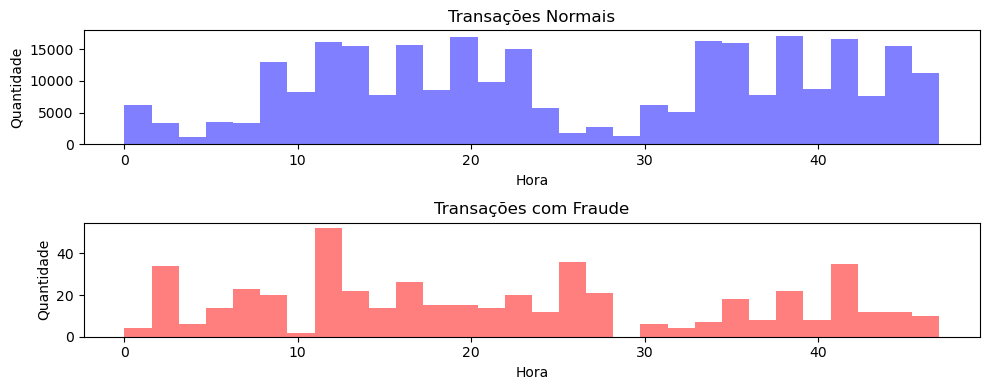

In [32]:
#@title ...
# Separando a base de dados com dados somente fraudulentos, e dados somente normais
normal = df[df['Class'] == 0]
fraude = df[df['Class'] == 1]

# Criando o subplot com duas áreas (1 linha, 2 colunas)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 4))

# Plotando o histograma de transações normais
ax[0].hist(normal.Hour, bins=30, color='blue', alpha=0.5)
ax[0].set_title('Transações Normais')
ax[0].set_xlabel('Hora')
ax[0].set_ylabel("Quantidade")

# Plotando o histograma de transações com fraude
ax[1].hist(fraude.Hour, bins=30, color='red', alpha=0.5)
ax[1].set_title('Transações com Fraude')
ax[1].set_xlabel('Hora')
ax[1].set_ylabel("Quantidade")

plt.tight_layout()

A seguir, é exibido um heatmap (mapa de calor) que representa as correlações entre as variáveis.

 Essas correlações indicam o quanto uma variável influencia a outra.

Neste contexto, em que estamos analisando transações fraudulentas, é importante destacar a coluna 'Class'. Quanto menos clara a cor da célula, maior é a influência dessa variável no valor da coluna 'Class'.

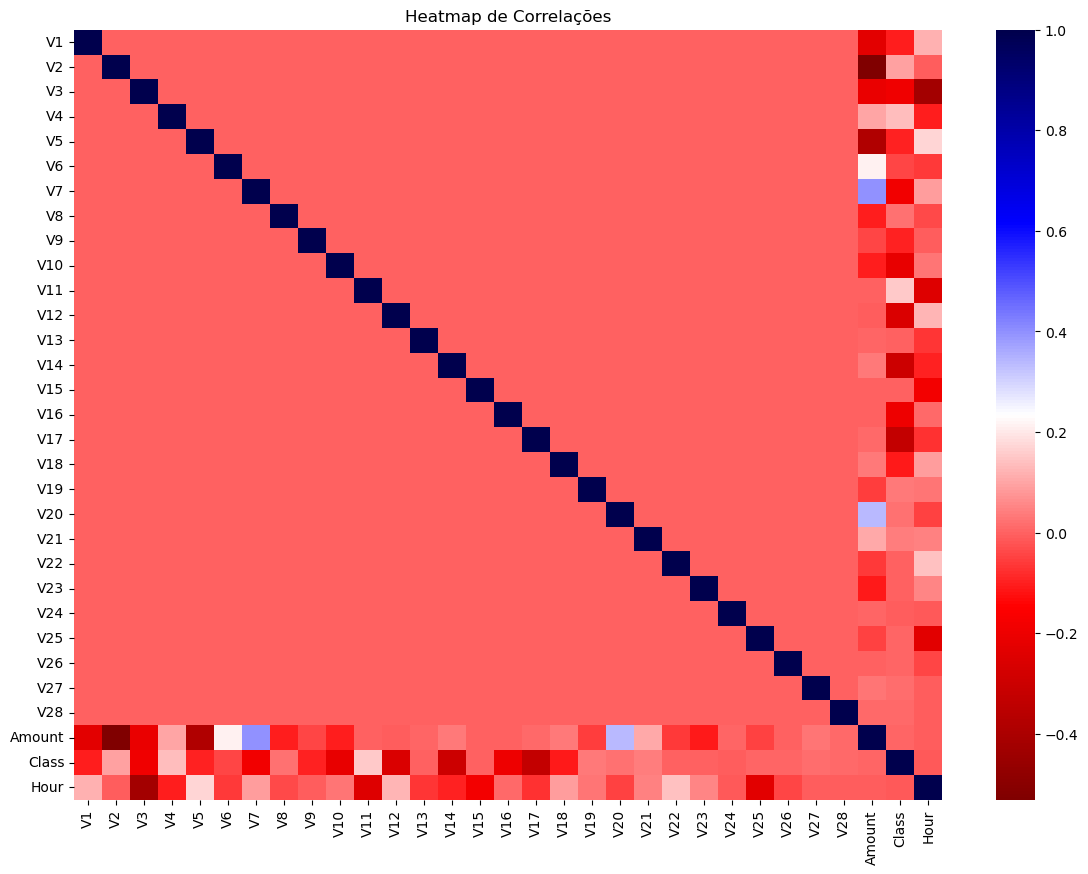

In [33]:
#@title ...
# Calcula a matriz de correlações
correlations = df.corr()

# Cria o heatmap de correlações
plt.figure(figsize=(14, 10))
sns.heatmap(correlations, cmap='seismic_r')

# Configurações adicionais
plt.title('Heatmap de Correlações')
plt.show()

## Criação dos modelos supervisionados de classificação
*Após alguns testes notei que remover as colunas Amount e Hour ajudariam numa melhor taxa de acerto.*

### Separação dos dados
Antes de criarmos os modelos, é importante observar um fato crucial. Nossa base de dados contém mais de 284.000 registros, sendo que menos de 1% deles são fraudes. Portanto, se desenvolvermos um modelo que classifique todos os registros como normais, tecnicamente ele terá uma taxa de acerto superior a 99%. Embora essa porcentagem seja excelente, usar esse modelo seria o mesmo que não usar nada.

Para contornar essa situação, usei classe RandomUnderSampler da biblioteca imblearn. Essa classe irá realizar o seguinte procedimento:
selecionar todos os registros da Classe 1 e, aleatoriamente, escolher a mesma quantidade de registros da Classe 0. Dessa forma, obteremos uma nova base de dados com uma distribuição equilibrada, contendo 50% de valores normais e 50% de registros fraudulentos.


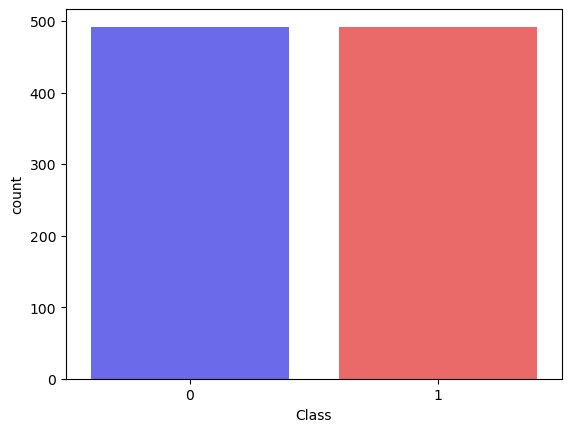

In [34]:
#@title Como podemos ver no gráfico agora a Class esta dividida igualmente.
# Criando a variavel X sem as colunas Amount e Hour, e sem a coluna Class que contém a resposta se é ou não fraude
X = df.drop(["Class", "Amount", "Hour"], axis=1)
y = df.Class

# usar técnica under-sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X=X, y=y)

# dividindo o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, shuffle=True)

# plotar a nova distribuição de classes
sns.countplot(x=y_rus, palette='seismic');

### Quais modelos e por quê?
Decidi criar e avaliar três modelos diferentes para a detecção de fraudes em cartões de crédito. São eles:

1. Regressão Logística: É amplamente utilizado na detecção de fraudes de cartões de crédito, especialmente para problemas de classificação binária (0, 1).

2. Random Forest: São modelos altamente eficazes para a detecção de fraudes em cartões de crédito. Eles possuem a capacidade de lidar com conjuntos de dados volumosos e capturar características importantes e relacionamentos não lineares.

3. SVM (Support Vector Machines): Têm sido amplamente empregadas na detecção de fraudes. Ao utilizar kernels adequados, as SVMs são especialmente úteis para identificar padrões complexos e transações fraudulentas.

Essas abordagens distintas nos permitirão avaliar e comparar o desempenho dos modelos, fornecendo uma perspectiva mais abrangente na detecção de fraudes em cartões de crédito.

In [35]:
#@title Instanciando e treinando os modelos de Regressão Logística, RandomForest e SVM

np.random.seed(2)
regressao = LogisticRegression(max_iter=1000).fit(X_train, y_train)
florest = RandomForestClassifier(max_samples=6, criterion="entropy").fit(X_train, y_train)
svm = SVC().fit(X_train, y_train)

In [36]:
#@title Fazendo as previsões em cima dos dados de teste

y_regressao = regressao.predict(X_test)
y_florest = florest.predict(X_test)
y_svm = svm.predict(X_test)

### Avaliando os modelos

Após criar e treinar os modelos, realizamos a previsão utilizando os dados de teste.

Agora, vamos analisar a matriz de confusão, que nos permite comparar os valores reais com os valores previstos pelo modelo.

Nosso objetivo é obter a maior precisão possível. Para isso, buscamos ter o maior número de acertos na diagonal principal, indicando que os valores foram previstos corretamente. Por outro lado, procuramos ter o menor número possível na diagonal secundária, que indica os valores previstos incorretamente.


A matriz de confusão é uma ferramenta valiosa para avaliar o desempenho dos nossos modelos de previsão. Ela nos fornece uma visão clara dos acertos e erros, permitindo-nos identificar áreas em que podemos melhorar e ajustar nossos modelos de detecção de fraudes em cartões de crédito.


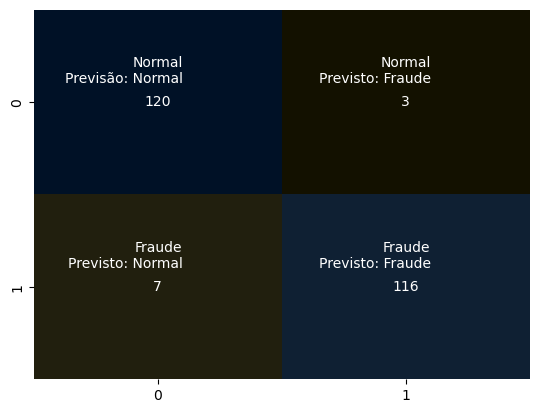

In [37]:
#@title Matriz de Confusão da Regressão Logistica
fig, ax = plt.subplots()

# cmap personalizado para gerar somente cores escuras em toda a matriz
cmap = sns.diverging_palette(80, 250, s=100, l=5, as_cmap=True)

# Criação do da matriz confusão usando um heatmap
sns.heatmap(confusion_matrix(y_test, y_regressao), annot=True, fmt=".3g", cmap=cmap, cbar=False, ax=ax)


# Adicionando rótulos personalizados
labels = [['Normal\nPrevisão: Normal', 'Normal\nPrevisto: Fraude'], ['Fraude\nPrevisto: Normal', 'Fraude\nPrevisto: Fraude']]
for i in range(len(labels)):
    for j in range(len(labels[i])):
        text = ax.text(j + 0.6, i + 0.25, labels[i][j], ha='right', va='top', color='white')

plt.show()

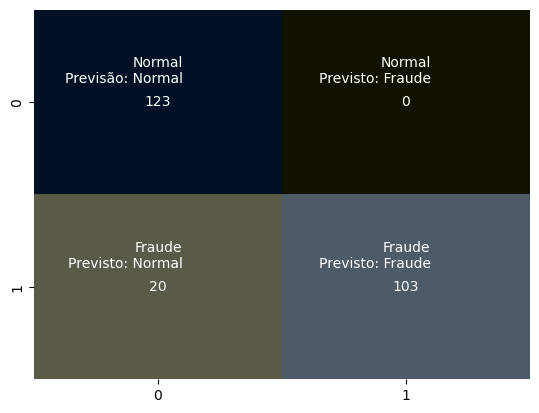

In [38]:
#@title Matriz de Confusão do RandomForest
fig, ax = plt.subplots()

sns.heatmap(confusion_matrix(y_test, y_florest), annot=True, fmt=".3g", cmap=cmap, cbar=False, ax=ax)

# Adicionando rótulos personalizados
labels = [['Normal\nPrevisão: Normal', 'Normal\nPrevisto: Fraude'], ['Fraude\nPrevisto: Normal', 'Fraude\nPrevisto: Fraude']]
for i in range(len(labels)):
    for j in range(len(labels[i])):
        text = ax.text(j + 0.6, i + 0.25, labels[i][j], ha='right', va='top', color='white')

plt.show()

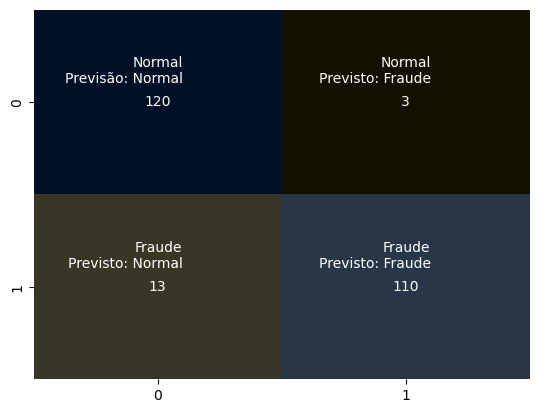

In [39]:
#@title Matriz de Confusão do SVM
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_svm), annot=True, fmt=".3g", cmap=cmap, cbar=False, ax=ax)

# Adicionando rótulos personalizados
labels = [['Normal\nPrevisão: Normal', 'Normal\nPrevisto: Fraude'], ['Fraude\nPrevisto: Normal', 'Fraude\nPrevisto: Fraude']]
for i in range(len(labels)):
    for j in range(len(labels[i])):
        text = ax.text(j + 0.6, i + 0.25, labels[i][j], ha='right', va='top', color='white')

plt.show()

### Acurácia, Precisão e Recall
No contexto geral, acurácia, precisão e recall são métricas comumente utilizadas na avaliação de modelos de classificação.

- Acurácia é calculada com os valores da diagonal principal divido pelo total de elementos da matriz de confusão.

- Precisão é uma métrica que mede a taxa de acerto das transações normais. Quanto menos transações **NORMAIS** classificadas errado, melhor.

- Recall calcula a taxa de acerto das transações fraudulentas. Quanto menos transações **FRAUDULENTAS** avaliadas errado, melhor.



Agora, surge a pergunta: qual dessas métricas é a mais importante nesse contexto, precisão ou recall? Na minha opinião, o recall é mais relevante. Isso ocorre porque, quando o legítimo dono do cartão realiza uma compra suspeita, ele possui várias formas de comprovar sua identidade e validar a transação. No entanto, quando um criminoso tenta fazer uma compra utilizando o cartão de outra pessoa, é crucial que o menor número possível de transações seja erroneamente considerado normal.

**Importânte: Essas métricas são o intervalo de valores entre 0 e 1. Então quanto mais próximo de 1, melhor.**

In [40]:
#@title Acurácia dos modelos
# imprimir a acurácia do modelo, recall e precisao
print("R Logistica: {:.3f}\n".format(accuracy_score(y_test, y_regressao)))
print("R Florest: {:.3f}\n".format(accuracy_score(y_test, y_florest)))
print("SVM: {:.3f}\n".format(accuracy_score(y_test, y_svm)))

R Logistica: 0.959

R Florest: 0.919

SVM: 0.935



In [41]:
#@title Precisão dos modelos
# imprimir relatório de classificação
print("R Logistica: {:.3f}\n".format(precision_score(y_test, y_regressao)))
print("R Florest: {:.3f}\n".format(precision_score(y_test, y_florest)))
print("Precisão SVM: {:.3f}\n".format(precision_score(y_test, y_svm)))

R Logistica: 0.975

R Florest: 1.000

Precisão SVM: 0.973



In [42]:
#@title Recall dos modelos
# imprimir relatório de classificação
print("R Logistica: {:.3f}\n".format(recall_score(y_test, y_regressao)))
print("R Florest: {:.3f}\n".format(recall_score(y_test, y_florest)))
print("Recall SVM: {:.3f}\n".format(recall_score(y_test, y_svm)))

R Logistica: 0.943

R Florest: 0.837

Recall SVM: 0.894



## Conclusão

A detecção de fraudes em cartões de crédito é um desafio complexo, mas por meio do nosso estudo, conseguimos obter resultados promissores. Em particular, o modelo de regressão logística demonstrou um desempenho consistente e altamente satisfatório em comparação com os outros dois modelos avaliados.

Este estudo nos permitiu compreender a importância de utilizar métricas como acurácia, precisão e recall para avaliar o desempenho dos modelos. Identificamos que o recall se mostrou especialmente relevante para garantir a detecção adequada de transações fraudulentas, minimizando as fraudes mal classificadas.

Através do ajuste contínuo de parâmetros e da exploração de outros modelos, acredito firmemente que podemos alcançar resultados ainda melhores.